In [ ]:
# Run if you want to get rid of water, leave only protein and make the molecules whole
! echo 1 | gmx trjconv -f ../dynamic.xtc -s ../dynamic.tpr -o vars/output_no_water.xtc -pbc mol # make the molecules whole again!
! echo 1 | gmx trjconv -f ../dynamic.gro -s ../dynamic.tpr -o vars/output_no_water.gro -pbc mol

In [1]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PSF, DCD, GRO, XTC
from MDAnalysis.analysis.rdf import InterRDF_s
import warnings
from MDAnalysis.analysis import contacts
from matplotlib import pyplot as plt
#https://docs.mdanalysis.org/2.7.0/documentation_pages/analysis/rdf.html
# suppress some MDAnalysis warnings about PSF files
warnings.filterwarnings('ignore')
from MDAnalysis.lib import distances
from matplotlib import pyplot as plt
import numpy as np
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor
import numpy as np


# maybe use unwrapped????

u= mda.Universe("vars/output_no_water.gro", "vars/output_no_water.xtc")
print(u)
print("Using MDAnalysis version", mda.__version__)

NUM_RES = 59
NUM_PROTEINS = 50
PROTEIN_LEN = 129
all_prot = u.select_atoms(f"bynum 1:6450")
prot1 = u.select_atoms(f"bynum 1:{PROTEIN_LEN}")
prot2 = u.select_atoms(f"bynum {PROTEIN_LEN+1}:{2*PROTEIN_LEN}")
print(len(prot1))
prot2_50 = u.select_atoms(f"bynum {PROTEIN_LEN+1}:6450")
print(len(prot2_50))
args = [[all_prot, all_prot]]


<Universe with 6450 atoms>
Using MDAnalysis version 2.7.0
129
6321


In [2]:
def plot_dist(res_dist, cutoff, vmax = 0):
    fig2, ax2 = plt.subplots()
    if vmax == 0:
        im2 = ax2.imshow(res_dist, aspect='auto', origin='lower')
    else:
        im2 = ax2.imshow(res_dist, aspect='auto', origin='lower', vmax=vmax)

    # add residue ID labels to axes
    tick_interval = 10
    ax2.set_yticks(np.arange(res_dist.shape[0])[::tick_interval])
    ax2.set_xticks(np.arange(res_dist.shape[1])[::tick_interval])
    # ax2.set_yticklabels(prot1.residues.resids[::tick_interval])
    # ax2.set_xticklabels(prot1.residues.resids[::tick_interval])

    # add figure labels and titles
    plt.ylabel('residue #')
    plt.xlabel('residue #')
    plt.title(f"Distance between center-of-mass of the residues, cutoff {cutoff}")

    # # colorbar
    cbar2 = fig2.colorbar(im2)
    cbar2.ax.set_ylabel('Contacts')
    plt.show()

def contacts_within_cutoff(u, group_a, group_b, radius=20):
    size1 = len(group_a.center_of_mass(compound='residues'))
    size2 = len(group_b.center_of_mass(compound='residues'))
    tot_contacts = np.zeros((size1,size2))
    for ts in u.trajectory:
        res_com1 = group_a.center_of_mass(compound='residues')
        res_com2 = group_b.center_of_mass(compound='residues')
         
        com_dist = distances.distance_array(res_com1, res_com2,
                                    box=u.dimensions)
        contact_mat = contacts.contact_matrix(com_dist, radius)
        # this way of doing average is slower but prevents from overflow
        tot_contacts = tot_contacts + contact_mat
    return tot_contacts


In [3]:

# Define the function to process contacts within a single job
def contacts_within_cutoff_job(gro_file, xtc_file, start_index, end_index, max_atoms, radius=20):
    u = mda.Universe(gro_file, xtc_file)  # Initialize a new Universe for each job
    prot_i = u.select_atoms(f"bynum {start_index}:{end_index}")
    prot_others = u.select_atoms(f"bynum 1:{max_atoms} and not bynum {start_index}:{end_index}")
    
    size1 = len(prot_i.center_of_mass(compound='residues'))
    size2 = len(prot_others.center_of_mass(compound='residues'))
    tot_contacts = np.zeros((size1, size2))

    for ts in u.trajectory:
        res_com1 = prot_i.center_of_mass(compound='residues')
        res_com2 = prot_others.center_of_mass(compound='residues')
        com_dist = distances.distance_array(res_com1, res_com2, box=u.dimensions)
        contact_mat = contacts.contact_matrix(com_dist, radius)
        tot_contacts += contact_mat  # In-place addition to avoid memory overhead

    return tot_contacts


# Main function to generate contact map
def generate_contact_map(gro_file, xtc_file, num_proteins, protein_len, num_res, radius):
    futures = []
    ress = []
    with ProcessPoolExecutor(max_workers=32) as executor:  # Use ProcessPoolExecutor for better performance
        for i in range(num_proteins):
            max_atoms = num_proteins * protein_len
            start_index = i * protein_len + 1
            end_index = (i + 1) * protein_len
            print(f"Submitting job for protein {i}")
            futures.append(executor.submit(contacts_within_cutoff_job, gro_file, xtc_file, start_index, end_index, max_atoms, radius))

        for future in concurrent.futures.as_completed(futures):
            print("job done")
            ress.append(future.result())  # Incrementally add each result directly to avg_self_contacts
            
    return ress

# Example for single radius value
# radius = 30
# ctcs = generate_contact_map("output_no_water.gro", "output_no_water.xtc", NUM_PROTEINS, PROTEIN_LEN, NUM_RES, radius=radius)
# avg_inter_contacts = np.zeros((NUM_RES, NUM_RES))
# for matrix in ctcs:
#     res_inter_reduced = np.zeros((matrix.shape[0], NUM_RES))
#     for ind in range(NUM_RES):
#         columns_to_average = matrix[:, ind::NUM_RES]
#         res_inter_reduced[:, ind] = columns_to_average.mean(axis=1)
#     avg_inter_contacts += res_inter_reduced 



Submitting job for protein 0
Submitting job for protein 1
Submitting job for protein 2
Submitting job for protein 3
Submitting job for protein 4
Submitting job for protein 5
Submitting job for protein 6
Submitting job for protein 7
Submitting job for protein 8
Submitting job for protein 9
Submitting job for protein 10
Submitting job for protein 11
Submitting job for protein 12
Submitting job for protein 13
Submitting job for protein 14
Submitting job for protein 15
Submitting job for protein 16
Submitting job for protein 17
Submitting job for protein 18
Submitting job for protein 19
Submitting job for protein 20
Submitting job for protein 21
Submitting job for protein 22
Submitting job for protein 23
Submitting job for protein 24
Submitting job for protein 25
Submitting job for protein 26
Submitting job for protein 27
Submitting job for protein 28
Submitting job for protein 29
Submitting job for protein 30
Submitting job for protein 31
Submitting job for protein 32
Submitting job for p

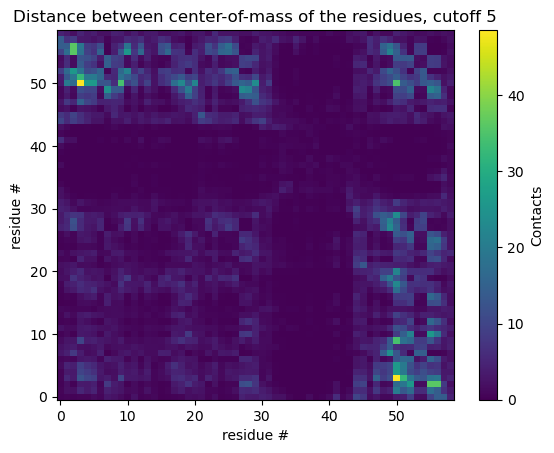

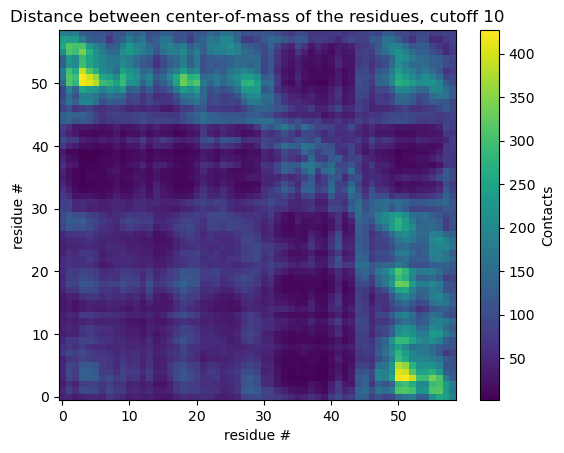

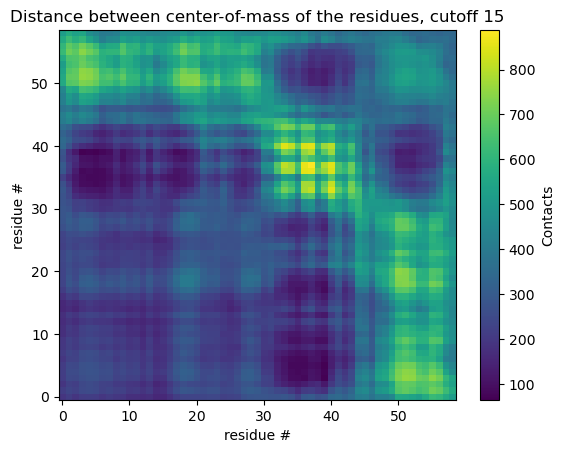

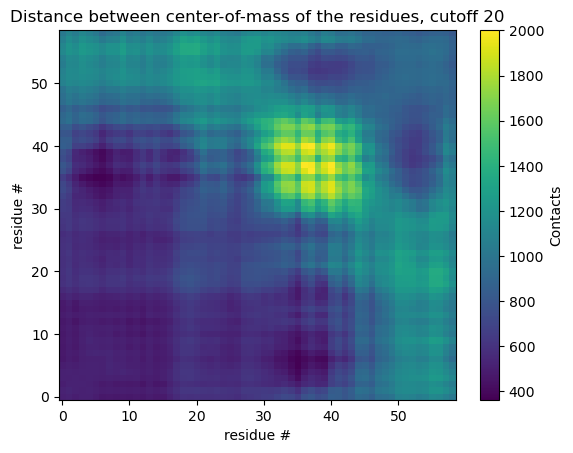

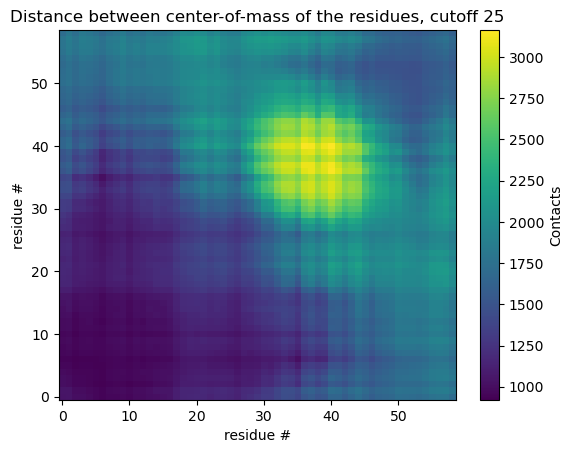

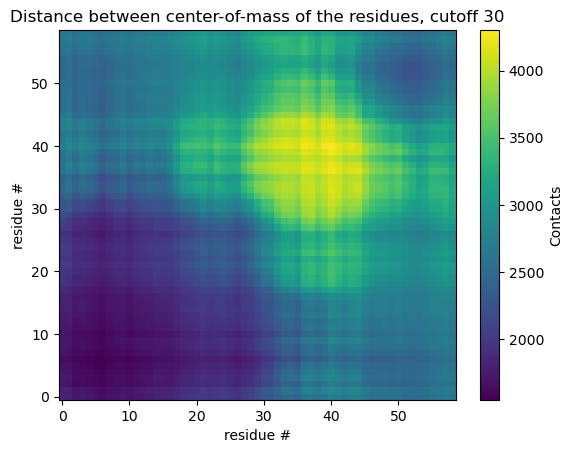

In [4]:
results = []
radii = [5, 10, 15, 20, 25, 30]
for radius in radii:
    avg_inter_contacts = np.zeros((NUM_RES, NUM_RES))
    ctcs = generate_contact_map("vars/output_no_water.gro", "vars/output_no_water.xtc", NUM_PROTEINS, PROTEIN_LEN, NUM_RES, radius=radius)
    for matrix in ctcs:
        res_inter_reduced = np.zeros((matrix.shape[0], NUM_RES))
        for ind in range(NUM_RES):
            columns_to_average = matrix[:, ind::NUM_RES]
            res_inter_reduced[:, ind] = columns_to_average.mean(axis=1)
        avg_inter_contacts += res_inter_reduced    
    results.append(avg_inter_contacts)
    
for i,radius in enumerate(radii):
    plot_dist(results[i], cutoff=radius)

In [5]:
def sef_contacts_job(gro_file, xtc_file, start_index, end_index, radius=20):
    u = mda.Universe(gro_file, xtc_file)  # Initialize a new Universe for each job
    prot_i = u.select_atoms(f"bynum {start_index}:{end_index}")
    
    size1 = len(prot_i.center_of_mass(compound='residues'))
    tot_contacts = np.zeros((size1, size1))

    for ts in u.trajectory:
        res_com1 = prot_i.center_of_mass(compound='residues')
        com_dist = distances.distance_array(res_com1, res_com1, box=u.dimensions)
        contact_mat = contacts.contact_matrix(com_dist, radius)
        tot_contacts += contact_mat  # In-place addition to avoid memory overhead

    return tot_contacts

def generate_self_contact_map(gro_file, xtc_file, num_proteins, protein_len, num_res, radius=20):
    futures = []
    ress = []
    with ProcessPoolExecutor(max_workers=32) as executor:  # Use ProcessPoolExecutor for better performance
        for i in range(num_proteins):
            start_index = i * protein_len + 1
            end_index = (i + 1) * protein_len
            print(f"Submitting job for protein {i}")
            futures.append(executor.submit(sef_contacts_job, gro_file, xtc_file, start_index, end_index, radius))

        for future in concurrent.futures.as_completed(futures):
            print("job done")
            ress.append(future.result())  # Incrementally add each result directly to avg_self_contacts
            
    return ress

self_contacts = generate_self_contact_map("vars/output_no_water.gro", "vars/output_no_water.xtc", NUM_PROTEINS, PROTEIN_LEN, NUM_RES, radius=15)
self_ct = np.zeros((NUM_RES, NUM_RES))
for ct in self_contacts:
    self_ct += ct

Submitting job for protein 0
Submitting job for protein 1
Submitting job for protein 2
Submitting job for protein 3
Submitting job for protein 4
Submitting job for protein 5
Submitting job for protein 6
Submitting job for protein 7
Submitting job for protein 8
Submitting job for protein 9
Submitting job for protein 10
Submitting job for protein 11
Submitting job for protein 12
Submitting job for protein 13
Submitting job for protein 14
Submitting job for protein 15
Submitting job for protein 16
Submitting job for protein 17
Submitting job for protein 18
Submitting job for protein 19
Submitting job for protein 20
Submitting job for protein 21
Submitting job for protein 22
Submitting job for protein 23
Submitting job for protein 24
Submitting job for protein 25
Submitting job for protein 26
Submitting job for protein 27
Submitting job for protein 28
Submitting job for protein 29
Submitting job for protein 30
Submitting job for protein 31
Submitting job for protein 32
Submitting job for p

Submitting job for protein 0
Submitting job for protein 1
Submitting job for protein 2
Submitting job for protein 3
Submitting job for protein 4
Submitting job for protein 5
Submitting job for protein 6
Submitting job for protein 7
Submitting job for protein 8
Submitting job for protein 9
Submitting job for protein 10
Submitting job for protein 11
Submitting job for protein 12
Submitting job for protein 13
Submitting job for protein 14
Submitting job for protein 15
Submitting job for protein 16
Submitting job for protein 17
Submitting job for protein 18
Submitting job for protein 19
Submitting job for protein 20
Submitting job for protein 21
Submitting job for protein 22
Submitting job for protein 23
Submitting job for protein 24
Submitting job for protein 25
Submitting job for protein 26
Submitting job for protein 27
Submitting job for protein 28
Submitting job for protein 29
Submitting job for protein 30
Submitting job for protein 31
Submitting job for protein 32
Submitting job for p

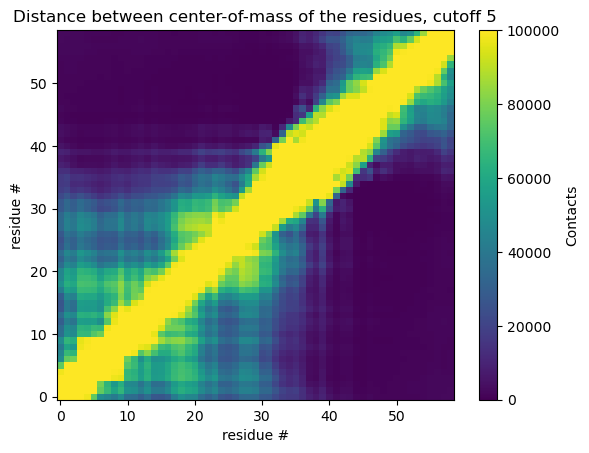

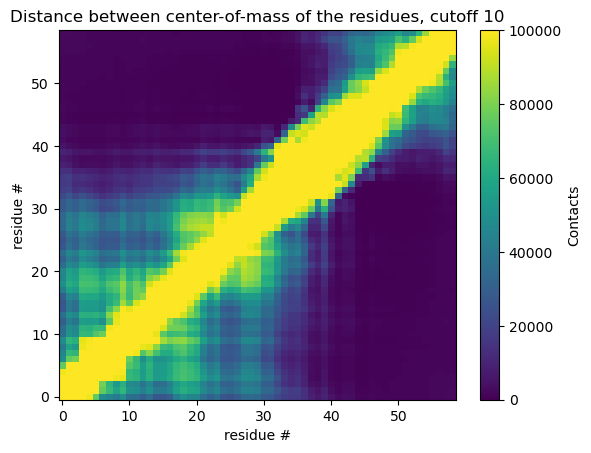

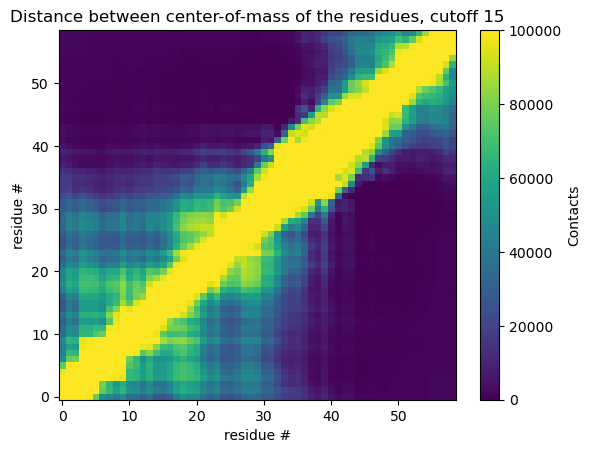

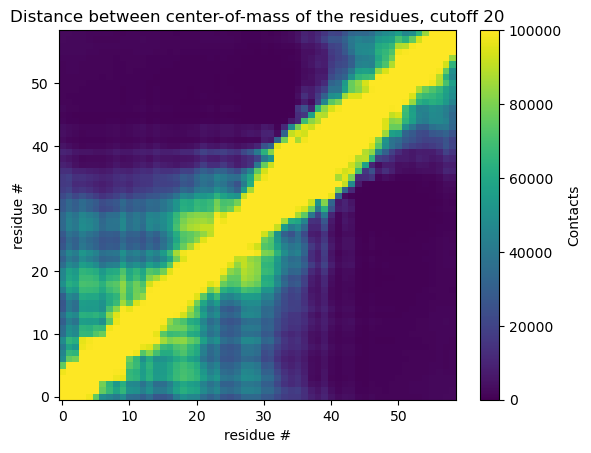

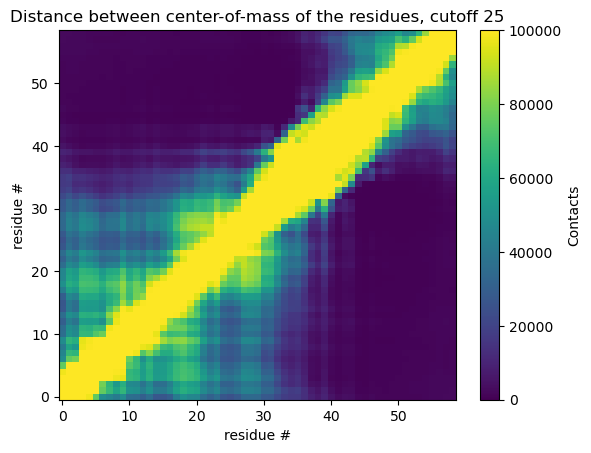

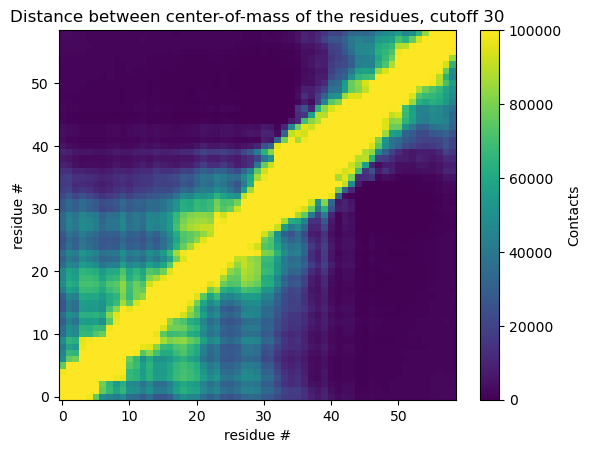

In [10]:
results = []
radii = [5, 10, 15, 20, 25, 30]
for radius in radii:
    self_contacts = generate_self_contact_map("vars/output_no_water.gro", "vars/output_no_water.xtc", NUM_PROTEINS, PROTEIN_LEN, NUM_RES, radius=15)
    self_ct = np.zeros((NUM_RES, NUM_RES))
    for ct in self_contacts:
        self_ct += ct
    results.append(self_ct)
    
for i, self_ctc in enumerate(results):
    plot_dist(self_ctc, radii[i])